In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import special
import mpmath as mp
%matplotlib inline

In [3]:
import classy
from classy import Class

In [4]:
LambdaCDM = Class()
LambdaCDM.set({'omega_b':0.022383,'omega_cdm':0.12011,'h':0.6732,'ln10^{10}A_s':3.0448,'n_s':0.96605,'tau_reio':0.0543})

# run class
LambdaCDM.compute()
bg = LambdaCDM.get_background()
H_data = bg['H [1/Mpc]']/LambdaCDM.h() #Hubble factor in units of h/Mpc
z_data = bg['z'] #redshift, off course
comoving_distance_data = bg['comov. dist.']*1000#*LambdaCDM.h() #comoving distance in units of Mpc/h

#now we spline them
from scipy.interpolate import CubicSpline
a_data = 1./(1. + z_data)
Hubble = CubicSpline(a_data , H_data)
comoving_distance = CubicSpline(a_data, comoving_distance_data)

In [5]:
def D_angular(z_i):
    a_i = 1/(1 + z_i)
    return a_i*comoving_distance(a_i)
def D_sl(z_s, z_l):
    a_s = 1/(1 + z_s)
    a_l = 1/(1 + z_l)
    return a_l*(comoving_distance(a_s) - comoving_distance(a_l))

In [6]:
def density(theta, theta_0):
    sigma = 0.3
    return np.exp(-0.5*np.sum((theta - theta_0[:, None, None]*np.ones_like(theta))**2/sigma**2, 0))/(2*np.pi*sigma**2)

In [7]:
from ezigzag import parse_args
from ezigzag.data import HDF5Dataset, TrainTestDataLoader

ds = HDF5Dataset("./data", meta_groups="**/metadata/*", collate=True)
dl = TrainTestDataLoader(ds, ds, batch_size=1, shuffle=False)

for i, batch in dl.tqdm():
      info = batch[1]  # dictionary with metadata like extent, units, etc.
      if i == 0:
            break
      ...

  0%|          | 0/4000 [00:00<?, ?it/s]


In [8]:
from ezigzag import parse_args
from ezigzag.data import HDF5Dataset, TrainTestDataLoader

ds = HDF5Dataset("./data", meta_groups="**/metadata/*", collate=True)
dl = TrainTestDataLoader(ds, ds, batch_size=1, shuffle=False)

for i, batch in dl.tqdm():
      info[i] = batch[1]  # dictionary with metadata like extent, units, etc.
      if i == 4000:
            break
      ...

100%|██████████| 4000/4000 [00:17<00:00, 226.72it/s]


In [9]:
import h5py
data = h5py.File('data/240818_tng50-1_dm_99_gids.1000.2000.hdf5', 'r')

galaxies_data = data['dm']['metadata']
galaxies = data['dm']['images']

N = np.size(galaxies[0, 0, :])
N_min = int(N*0.5 - 50)
N_max = int(N*0.5 + 50)

galaxies = galaxies[:, N_min:N_max, N_min:N_max]

In [10]:
X = np.zeros([4000, N])
X.shape

(4000, 512)

In [11]:
for i in range(0, 4000):
    X[i, :] = np.linspace(info[i]['extent'][0][0], info[i]['extent'][0][1], N)

X = X[:, N_min:N_max]

In [12]:
galaxies.shape

(4000, 100, 100)

In [13]:
#It takes the array on which the bidimensional density is computed, and the bidimensional density itself
def newtonian_potential_grid(theta_grid, Sigma):
    dtheta = theta_grid[1] - theta_grid[0]
    eps = 0.0001*dtheta #softening length
    integrand = Sigma[:, :, None, None]*np.log(np.sqrt((theta_grid[:, None, None, None] - theta_grid[None, None, :, None])**2 + (theta_grid[None, :, None, None] - theta_grid[None, None, None, :])**2 + eps**2) )
    result = np.sum(integrand, axis = (0, 1))
    return dtheta*dtheta*(result - np.ones_like(result)*result[0, 0])

In [14]:
GM = 4.302*1e-6 #in kpc (km/s)^2
c_light = 2.99792*1e+5 #in km/s

GM_c2 = GM/(c_light*c_light)
GM_c2 #(in kpc)

4.78663516644209e-17

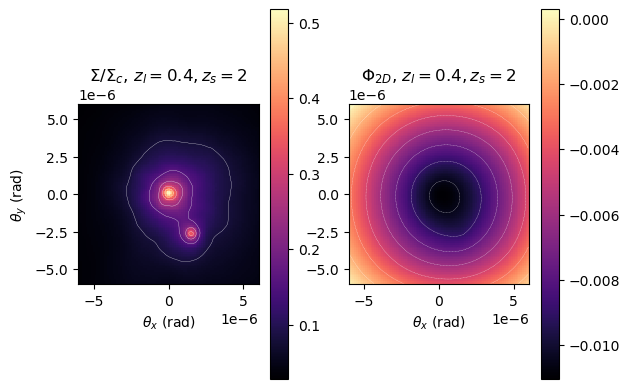

In [15]:
plt.subplot(1, 2, 1)
i = 1

z_l = 0.4
z_s = 2

theta = X[i, :]/D_angular(z_l)
Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
plt.pcolormesh(theta, theta, galaxies[i, :, :]/Sigma_c , cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, galaxies[i, :, :]/Sigma_c , colors = 'white', linewidths = 0.2)
plt.title('$\Sigma/\Sigma_c$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.ylabel('$\\theta_y$ (rad)')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(theta, theta, newtonian_potential_grid(theta, galaxies[i, :, :]), cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, newtonian_potential_grid(theta, galaxies[i, :, :]), colors = 'white', linewidths = 0.2)
plt.title('$\Phi_{2D}$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.gca().set_aspect('equal')


In [16]:
def lensing_potential_map(z_s, z_l, theta_grid, Sigma):
    dtheta = theta_grid[1] - theta_grid[0]
    Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
    eps = 0.0001*dtheta #softening length
    integrand = Sigma[:, :, None, None]*np.log(np.sqrt((theta_grid[:, None, None, None] - theta_grid[None, None, :, None])**2 + (theta_grid[None, :, None, None] - theta_grid[None, None, None, :])**2 + eps**2) )
    result = np.sum(integrand, axis = (0, 1))/np.pi
    return dtheta*dtheta*(result/Sigma_c)# - np.ones_like(result)*result[0, 0]/Sigma_c)

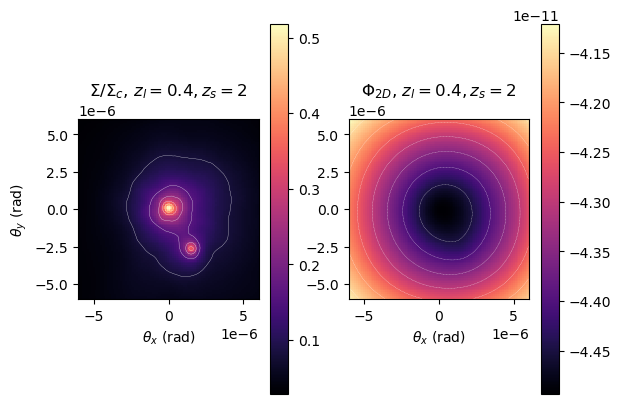

In [42]:
plt.subplot(1, 2, 1)
i = 1

z_l = 0.4
z_s = 2

theta = X[i, :]/D_angular(z_l)
Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
plt.pcolormesh(theta, theta, galaxies[i, :, :]/Sigma_c , cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, galaxies[i, :, :]/Sigma_c , colors = 'white', linewidths = 0.2)
plt.title('$\Sigma/\Sigma_c$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.ylabel('$\\theta_y$ (rad)')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(theta, theta, lensing_potential_map(z_s, z_l, theta, galaxies[i, :, :]), cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, lensing_potential_map(z_s, z_l, theta, galaxies[i, :, :]), colors = 'white', linewidths = 0.2)
plt.title('$\Phi_{2D}$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.gca().set_aspect('equal')

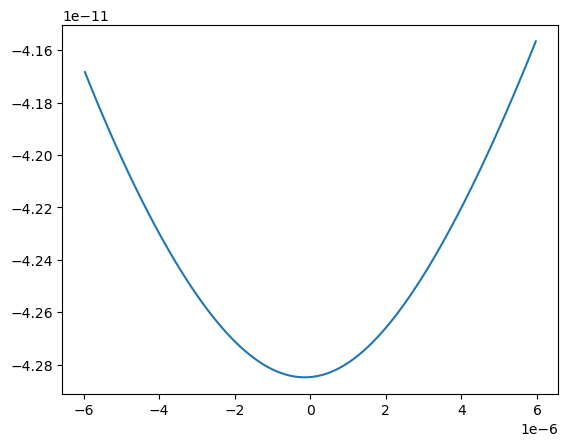

In [38]:
plt.plot(theta, lensing_potential_map(z_s, z_l, theta, galaxies[i, :, :])[:, 10])

In [44]:
def lensing_potential(theta_p, z_s, z_l, theta_grid, Sigma):
    dtheta = theta_grid[1] - theta_grid[0]
    Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
    eps = 0.0001*dtheta #softening length
    integrand = Sigma[:, :]*np.log(np.sqrt((theta_p[0]*np.ones_like(theta_grid[:, None]) - theta_grid[:, None])**2 + (theta_p[1]*np.ones_like(theta_grid[None, :]) - theta_grid[None, :])**2 + eps**2) )
    result = np.sum(integrand)/np.pi
    return dtheta*dtheta*(result/Sigma_c)# - np.ones_like(result)*result[0, 0]/Sigma_c)

In [ ]:
theta_p = np.asarray([0.5, 0.1])
lensing_potential(theta_p, z_s, z_l, theta, galaxies[i, :, :])

def alpha(theta_p, z_s, z_l, theta_grid, Sigma):
    theta_x, theta_y = theta_p
    dtheta = 1*(theta_grid[1] - theta_grid[0])
    #x component
    theta_plus = np.asarray([theta_x + dtheta, theta_y])
    theta_min = np.asarray([theta_x - dtheta, theta_y])
    alpha_x = 0.5*(lensing_potential(theta_plus, z_s, z_l, theta_grid, Sigma) - lensing_potential(theta_min, z_s, z_l, theta_grid, Sigma))/dtheta
    
    #y component
    theta_plus = np.asarray([theta_x, theta_y + dtheta])
    theta_min = np.asarray([theta_x, theta_y - dtheta])
    alpha_y = 0.5*(lensing_potential(theta_plus, z_s, z_l, theta_grid, Sigma) - lensing_potential(theta_min, z_s, z_l, theta_grid, Sigma))/dtheta
    
    return alpha_x, alpha_y

In [74]:
z_l = 0.18
z_s = 2
theta_p = np.asarray([-1.348, 0.966])*4.8*1e-6
alpha_x, alpha_y = alpha(theta_p, z_s, z_l, theta, galaxies[i, :, :])
alpha_x, alpha_y

(-3.346250956850139e-07, 2.0469233706135276e-07)